
# Basic building blocks of PyTorch

* **Tensors**: PyTorch’s main data structure. If a tensor’s requires_grad attribute is set to True, all operations on it will be tracked by autograd.

* **Computation Graph**: PyTorch builds a dynamic computation graph. Each node in the graph corresponds to a tensor operation (e.g., matrix multiplication, addition), and edges represent gradients between tensors.

* **Backward Pass**: After performing the forward pass, PyTorch can compute gradients by calling .backward() on the loss tensor. This traces back through the graph and accumulates the gradients in the .grad attribute of each leaf tensor.

# Deep dive into autograd in PyTorch

- Implementing backpropagation by hand is like programming in assembly language,
You will never have to do it, but it is important for having mental model of how everything works

- Automatic differentiation (`autodiff`) a general way of taking a program which computes value, and automatically constructs a procedure for computing derivatives of the values.
    * It is **NOT** finite differences. Hence, no “huge” numerical errors are induced. It is linear in cost of computing the values and numerically stable.
    * It is **NOT** Symbolic differentiation as well, which if not optimized could result in redundant expressions.
- Backpropagation is the special case of autodiff applied to neural nets. This is however used synonymously
- Autograd (`autograd`) is the name of the package within PyTorch. It uses reverse automatic differentiation.

- `autograd` will convert program into a sequence of primitive operations which have specified routines for computing derivatives. It is a computing engine.

- `autograd` will record all the operations that created the data as you execute operations (forward pass), creating a Directed Acyclic Graph (DAG).
Leaves are input tensors and roots are the output tensors after an operation. By tracing from roots to leaves, one can compute the gradients using chain rule. Hence it is called as reverse automatic differentiation engine.


In [33]:
!pip install numpy matplotlib torch mlxtend torchviz

In [34]:
from IPython.display import Image
%matplotlib inline

### Defining some global settings


In [35]:
import torch
tkwargs = {'dtype': torch.float,
           'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
           }

print (tkwargs)

{'dtype': torch.float32, 'device': device(type='cpu')}


## Example: Basic Autograd in Action

### Step 1: Creating tensors with `requires_grad`


In [36]:
import torch

# Create a tensor and set requires_grad=True to track its gradients
x = torch.tensor([2.0, 3.0], requires_grad=True, **tkwargs)
y = torch.tensor([1.0, 2.0], requires_grad=True, **tkwargs)
c = torch.tensor([3.0, 4.0], requires_grad=True, **tkwargs)
print (f"x: {x}")
print (f"y: {y}")
print (f"c: {c}")


x: tensor([2., 3.], requires_grad=True)
y: tensor([1., 2.], requires_grad=True)
c: tensor([3., 4.], requires_grad=True)


`requires_grad=True` tells PyTorch to start tracking all operations on these tensors for gradient computation.

### Perform operations on Tensors

In [37]:
# Perform some operations
z = x * y + c
loss = torch.mean(torch.rand(z.shape, **tkwargs) - z) ** 2
print(f"z: {z}")  # z is an intermediate tensor in the computation
print(f"loss: {loss}")  # w is the final result (a scalar)


z: tensor([ 5., 10.], grad_fn=<AddBackward0>)
loss: 54.06960678100586


### Leaf tensor vs root tensor (nodes)

In PyTorch, tensors as a result from operations are different from `base` tensors

#### Leaf Tensors

* Is created by the user (e.g., directly through a tensor creation function like torch.tensor() or torch.randn()).

* Has `requires_grad=True` (meaning it will be tracked for gradient computation).

* Does not result from a differentiable operation (i.e., it is not derived from other tensors that are part of a computational graph).

* **Originating tensor**: It is a tensor that is created by the user and not derived from other operations in the computational graph.

* **Gradient accumulation**: Gradients will accumulate directly in the .grad attribute of leaf tensors during backpropagation.

* **Not further differentiable**: Once you perform operations on a leaf tensor, the result is no longer a leaf tensor because it depends on the leaf tensor(s) through differentiable operations.

#### ROOT tensor

A root tensor is the final tensor in a computational graph. It is typically the tensor on which you call .backward() to initiate the backpropagation process. In most cases, this is a scalar value (e.g., a loss tensor) because gradients are defined with respect to a scalar quantity.

* **End of computation**: The root tensor is the result of all the operations performed during the forward pass.

* **Gradient propagation**: When .backward() is called on the root tensor, the gradients propagate backward through the computational graph, updating all tensors that were part of the graph (particularly leaf tensors with requires_grad=True).

* **Usually a scalar** (not strictly): In practice, the root tensor is often a scalar (e.g., loss), as gradients are typically computed with respect to a single quantity.


> [!NOTE]  Non-leaf tensors do not store gradients. If you need to inspect intermediate gradients, you must keep track of them separately. For example, if you want to compute gradients for non-leaf tensors, you can call `.retain_grad()` on them before performing backpropagation.

In [38]:
print (f"x is a leaf tensor? {x.is_leaf}, {x}")
print (f"y is a leaf tensor? {y.is_leaf}, {y}")
print (f"c is a leaf tensor? {c.is_leaf}, {c}")
print (f"z is a leaf tensor? {z.is_leaf}, {z}")
print (f"loss is a leaf tensor? {loss.is_leaf}, {loss}")

x is a leaf tensor? True, tensor([2., 3.], requires_grad=True)
y is a leaf tensor? True, tensor([1., 2.], requires_grad=True)
c is a leaf tensor? True, tensor([3., 4.], requires_grad=True)
z is a leaf tensor? False, tensor([ 5., 10.], grad_fn=<AddBackward0>)
loss is a leaf tensor? False, 54.06960678100586


### Another Example on leaf and root nodes

Let us consider the following

$$
z = \text{mean}(x * y + c)
$$

*Note how we are implementing these. This will become clear as we go through this notebook*


In [39]:
# Create a tensor and set requires_grad=True to track its gradients
x = torch.tensor([2.0, 3.0], requires_grad=True, **tkwargs)
y = torch.tensor([1.0, 2.0], requires_grad=True, **tkwargs)
c = torch.tensor([3.0, 4.0], requires_grad=True, **tkwargs)

# step 1: multiply x and y
r1 = torch.mul(x, y)
# r1.retain_grad()
# step 2: add r1 with c
w = torch.add(r1, c)
# step 3: Take mean of w
z = torch.mean(w)



print (f"x is a leaf tensor? {x.is_leaf}, {x}")
print (f"y is a leaf tensor? {y.is_leaf}, {y}")
print (f"c is a leaf tensor? {c.is_leaf}, {c}")
print (f"r1 is a leaf tensor? {r1.is_leaf}, {r1}")
print (f"w is a leaf tensor? {w.is_leaf}, {w}")
print (f"z is a leaf tensor? {z.is_leaf}, {z}")


x is a leaf tensor? True, tensor([2., 3.], requires_grad=True)
y is a leaf tensor? True, tensor([1., 2.], requires_grad=True)
c is a leaf tensor? True, tensor([3., 4.], requires_grad=True)
r1 is a leaf tensor? False, tensor([2., 6.], grad_fn=<MulBackward0>)
w is a leaf tensor? False, tensor([ 5., 10.], grad_fn=<AddBackward0>)
z is a leaf tensor? False, 7.5


In [40]:
# print the gradients after z.backward()
z.backward()


print ("gradients of x", x.grad.tolist())
print ("gradients of y", y.grad.tolist())
print ("gradients of c", c.grad.tolist())

gradients of x [0.5, 1.0]
gradients of y [1.0, 1.5]
gradients of c [0.5, 0.5]


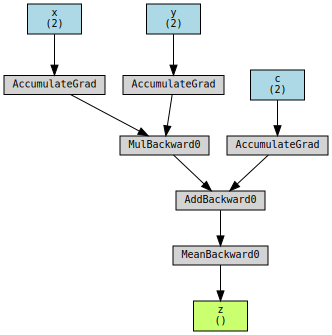

In [41]:
# @title `torchviz`
import torchviz

torchviz.make_dot(z, {'x': x, 'y': y, 'c': c, 'z': z, 'w': w, 'r1': r1})

In [ ]:
#@title Try to compute backward of z again

z.backward()

In [43]:
#@title Can we get gradients $\frac{\partial z}{\partial r_{1}}$?

print (r1.grad) # Mind this is dz_dr1

# Fix it by explicitly tracking its gradient as r1.retain_grad()

None


<ipython-input-43-3463133861ff>:3: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print (r1.grad) # Mind this is dz_dr1


### Extending to a torch model (classical way)

In [44]:
import torch
import torch.nn as nn

# Example model with named and unnamed parameters
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        # Named parameters (from layers)
        self.fc1 = nn.Linear(1, 3)
        self.fc2 = nn.Linear(3, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialize the model
model = SimpleNN()

# Print named parameters
#print("Named Parameters:")
#for name, param in model.named_parameters():
#    print(f"Name: {name}, requires_grad: {param.requires_grad}")

# Print unnamed parameters (using model.parameters())
#print("\nUnnamed Parameters:")
#for param in model.parameters():
#    if param not in model.named_parameters():
#        print(f"Parameter without a name: {param}, requires_grad: {param.requires_grad}")


inputs = torch.rand(1)
outputs = model(inputs)
print ("INPUTS")
print (inputs)

print ("-----------")

print ("outputs")
print (outputs)


INPUTS
tensor([0.1872])
-----------
outputs
tensor([0.6519], grad_fn=<SigmoidBackward0>)


What happened to the intermediate steps? What happened to weights and the intermediate `ReLU`.

### To inspect the entire computational graph we can use `torchviz`


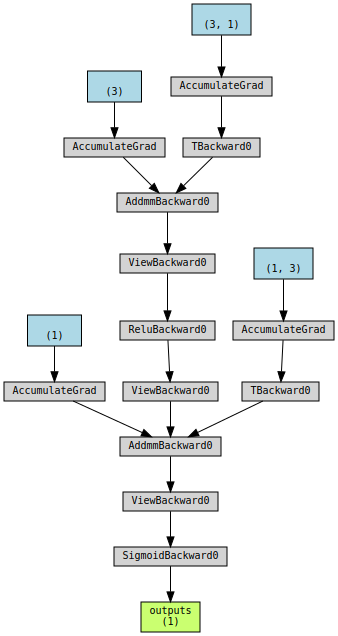

In [45]:
import torchviz

torchviz.make_dot(outputs, {'inputs': inputs, 'outputs': outputs})

### Lets do it with a simpler implementation



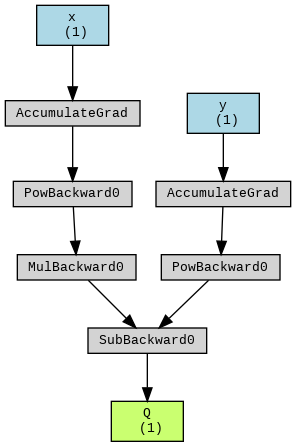

In [46]:
#@title Lets do $Q = 3 x^{2} - y^{2}$
import torch
from torchviz import make_dot

x = torch.randn(1, requires_grad=True)
y = torch.randn(1, requires_grad=True)

Q = 3 * x**2 - y**2

make_dot(Q, params={'x': x, 'y': y, 'Q': Q}).render("Q_graph", format="png")

from IPython.display import Image
Image('Q_graph.png')

## Computing gradients via automatic differentiation and GradientTape


In [47]:
model.fc2.weight.grad

### Computing the gradients of the loss with respect to trainable variables

In [48]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])


z = torch.add(torch.mul(w, x), b)
z.retain_grad()

loss = (y-z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)


dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [49]:
# verifying the computed gradient dL/dw
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


### PyTorch Autodifferentiation vs. Manual Gradient Calculation through Staged Computation

Say from before, if we want to push the value of `z` through a signmoid function, then we can now explore how a complex function can be broken down into a composition of simpler functions. We will demonstrate how automatic differentiation (autodiff) in PyTorch efficiently computes gradients by leveraging the chain rule, thus offering a scalable solution for handling more sophisticated computations.

Consider the task of calculating the gradient of the *sigmoid function*:
$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$
This function can be expressed as a composition of several elementary functions, where $\sigma(z) = s(c(b(a(z))))$. Each of these represents a simple mathematical transformation:

1. $$ a(z) = -z $$

2. $$ b(a) = e^a $$

3. $$ c(b) = 1 + b $$

4. $$ s(c) = \frac{1}{c} $$

By staging the computation, we introduce intermediate variables that correspond to simple expressions. This stepwise approach simplifies the process of calculating local gradients, making each stage straightforward to compute. To find the overall gradient, we can combine these local gradients using the chain rule.

The following figure illustrates the computation graph for this staged process, highlighting the flow of information from the input to the output.

![Gradient Computation Image](https://drive.google.com/uc?id=1xwJOoWH3_n-2zFHlvKTMWNo5KtNmqzxL)

Given an input $x$, and an output represented by node $s$, we aim to compute the derivative of $s$ with respect to $x$, denoted as $\frac{\partial s}{\partial x}$. Using the chain rule, this becomes:
$$
\frac{\partial s}{\partial z} = \frac{\partial s}{\partial c} \cdot \frac{\partial c}{\partial b} \cdot \frac{\partial b}{\partial a} \cdot \frac{\partial a}{\partial z}
$$


This staged manual computation of gradients, while feasible, can become tedious and error-prone, especially as the complexity of the function increases. The real power of PyTorch lies in how it automates this entire process using its built-in autodifferentiation engine.

### How PyTorch Alleviates This

PyTorch's `autograd` mechanism automatically tracks operations performed on tensors and constructs the underlying computation graph dynamically. When the `.backward()` function is called, PyTorch traverses the graph in reverse (backpropagation), efficiently computing gradients using the chain rule, without requiring manual intervention.

#### Benefits of PyTorch's `autograd`:
1. **Automatic Gradient Calculation**: No need to manually apply the chain rule for complex expressions, as PyTorch tracks all operations and calculates gradients for you.
2. **Efficient and Scalable**: PyTorch can handle large-scale models with many parameters, seamlessly updating gradients during training.
3. **Dynamic Graph**: Unlike static frameworks, PyTorch builds the computation graph dynamically during the forward pass. This makes it flexible for models that require runtime decisions, like varying network architectures or data flow.
4. **Error-Free Gradient Computation**: Manual gradient computations, especially in deep networks, can lead to mistakes. PyTorch alleviates this by providing reliable, automatic differentiation, freeing the user to focus on the high-level structure of the model.




In [50]:
import torch
import numpy as np

def sigmoid(x):
    """
    Sigmoid function re-implemented for educational purposes.
    In practice, use `torch.sigmoid` for performance and reliability.
    """
    return 1.0 / (1.0 + torch.exp(-x))

def grad_sigmoid_pytorch(x):
    """
    Computes the gradient of the sigmoid function using PyTorch's autograd.
    This demonstrates how PyTorch's autodiff engine tracks operations and
    computes the gradient automatically.
    """
    # Ensure x requires gradient computation
    x = x.clone().requires_grad_(True)
    # Perform the forward pass
    y = sigmoid(x)
    # Compute the gradient of y w.r.t. x
    y.backward()
    # Return the gradient of x (dy/dx)
    return x.grad

def grad_sigmoid_manual(x):
    """
    Manually computes the gradient of the sigmoid function by breaking down
    the computation into intermediate steps, following the chain rule.

    This process stages the computation, showing each step from the
    forward pass and how local gradients are computed during backpropagation.
    """
    # Forward pass with intermediate steps
    a = -x  # The negation step in the exponent
    b = np.exp(a)  # The exponentiation, e^{-x}
    c = 1 + b  # Adding 1 in the denominator
    s = 1.0 / c  # The final sigmoid output, 1 / (1 + e^{-x})

    # Backward pass (manual computation of gradients)
    dsdc = -1.0 / (c ** 2)  # Gradient of the reciprocal function
    dsdb = dsdc * 1  # Gradient of the addition
    dsda = dsdb * torch.exp(a)  # Gradient of the exponential
    dsdx = dsda * (-1)  # Gradient of the negation (chain rule applied)

    return dsdx

def grad_sigmoid_symbolic(x):
    """
    Computes the gradient of the sigmoid function using the known analytical
    derivative: d(sigmoid(x))/dx = sigmoid(x) * (1 - sigmoid(x)).
    This method leverages the symbolic representation of the gradient.
    """
    # Forward pass: compute sigmoid(x)
    s = sigmoid(x)
    # Compute gradient using the symbolic form of the derivative
    dsdx = s * (1 - s)
    return dsdx

# Input tensor for testing
input_x = torch.tensor([2.0])

# Compare the results of manual, PyTorch autograd, and symbolic gradient computations
print("Autograd (PyTorch):", grad_sigmoid_pytorch(input_x).item())
print("Manual (Staged Computation):", grad_sigmoid_manual(input_x).item())
print("Symbolic (Analytical Derivative):", grad_sigmoid_symbolic(input_x).item())


Autograd (PyTorch): 0.10499356687068939
Manual (Staged Computation): 0.10499357432126999
Symbolic (Analytical Derivative): 0.10499362647533417


## More complex example

Lets now create a more complex example with
- Input Layer - 1
- Hidden Layer - 2
- Ouput Layer - 1




In [51]:
# @title Coding this up manually is harder as you can see.
import torch
import numpy as np

# Activation functions
def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

def relu(x):
    return torch.maximum(torch.tensor(0.0), x)

# Gradient of sigmoid using symbolic derivative
def grad_sigmoid_symbolic(s):
    return s * (1 - s)

# Gradient of ReLU using symbolic derivative
def grad_relu_symbolic(x):
    return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

# Forward pass for multi-layer neural network
def forward_pass(x, w1, w2, w3):
    # Hidden layer 1 (ReLU activation)
    z1 = w1 @ x
    h1 = relu(z1)

    # Hidden layer 2 (Sigmoid activation)
    z2 = w2 @ h1
    h2 = sigmoid(z2)

    # Output layer (no activation)
    z3 = w3 @ h2
    return z1, h1, z2, h2, z3

# Manual backward pass
def backward_pass_manual(x, w1, w2, w3, y_true, z1, h1, z2, h2, y_pred):
    loss = (y_pred - y_true).pow(2).mean()

    grad_output = 2 * (y_pred - y_true)

    grad_w3 = grad_output * h2.T

    # Backprop through layer 2 (Sigmoid)
    grad_h2 = grad_output * w3.T  # Shape: (2, 1)
    grad_z2 = grad_h2 * grad_sigmoid_symbolic(h2)  # Shape: (2, 1)
    grad_w2 = grad_z2 @ h1.T  # Shape: (2, 2)

    # Backprop through layer 1 (ReLU)
    grad_h1 = w2.T @ grad_z2  # Corrected shape: (2, 1)
    grad_z1 = grad_h1 * grad_relu_symbolic(z1)  # Shape: (2, 1)
    grad_w1 = grad_z1 @ x.T  # Shape: (2, 1)

    return grad_w1, grad_w2, grad_w3

# Autograd backward pass
def backward_pass_autograd(x, w1, w2, w3, y_true):
    x.requires_grad_(True)
    w1.requires_grad_(True)
    w2.requires_grad_(True)
    w3.requires_grad_(True)

    _, _, _, _, y_pred = forward_pass(x, w1, w2, w3)

    loss = (y_pred - y_true).pow(2).mean()

    loss.backward()

    return w1.grad, w2.grad, w3.grad

# Initialize weights and input
x = torch.tensor([[1.0]], requires_grad=True)  # Input
w1 = torch.tensor([[0.5], [1.0]], requires_grad=True)  # Weights for layer 1 (2x1)
w2 = torch.tensor([[0.3, -0.7], [0.8, 0.2]], requires_grad=True)  # Weights for layer 2 (2x2)
w3 = torch.tensor([[0.2, -0.4]], requires_grad=True)  # Weights for output layer (1x2)
y_true = torch.tensor([1.0])  # True label (target)

# Forward pass to obtain intermediate values
z1, h1, z2, h2, y_pred = forward_pass(x.detach(), w1.detach(), w2.detach(), w3.detach())

# Compute gradients manually
grad_w1_manual, grad_w2_manual, grad_w3_manual = backward_pass_manual(x.detach(), w1.detach(), w2.detach(), w3.detach(), y_true, z1, h1, z2, h2, y_pred)

# Compute gradients using PyTorch autograd
grad_w1_autograd, grad_w2_autograd, grad_w3_autograd = backward_pass_autograd(x, w1, w2, w3, y_true)

# Display the results
print("Manual Gradients:")
print("grad_w1_manual:", grad_w1_manual)
print("grad_w2_manual:", grad_w2_manual)
print("grad_w3_manual:", grad_w3_manual)

print("\nAutograd Gradients:")
print("grad_w1_autograd:", grad_w1_autograd)
print("grad_w2_autograd:", grad_w2_autograd)
print("grad_w3_autograd:", grad_w3_autograd)


Manual Gradients:
grad_w1_manual: tensor([[0.1405],
        [0.1204]])
grad_w2_manual: tensor([[-0.0550, -0.1100],
        [ 0.1085,  0.2169]])
grad_w3_manual: tensor([[-0.8672, -1.5303]])

Autograd Gradients:
grad_w1_autograd: tensor([[0.1405],
        [0.1204]])
grad_w2_autograd: tensor([[-0.0550, -0.1100],
        [ 0.1085,  0.2169]])
grad_w3_autograd: tensor([[-0.8672, -1.5303]])


### Computing the gradient of a functional form as well. Just making sure we understand the math.


Let us consider to compute the value

$$f(x) = \sin{(x)}$$
where $x \in [0, 2\pi]$

In [52]:
# create a linspace in x from -5 to 5
x = torch.linspace(0., 2*torch.pi, 100, requires_grad=True, **tkwargs)
z = torch.sin(x)

# torch.autograd.grad() computes the gradient of z with respect to x using chain rule.
# grad_outputs is the gradient of the output with respect to z.
# This is where various layer outputs can be used to compute the gradient of the loss with respect to the input.
dz_dx = torch.autograd.grad(outputs=z, inputs=x, grad_outputs=z.data.new(z.shape).fill_(1), create_graph=True)[0]
# This is same as
# dz_dx = z.backward(torch.ones_like(z), retain_graph=True) # oneslike(z) is equivalent to grad_outputs

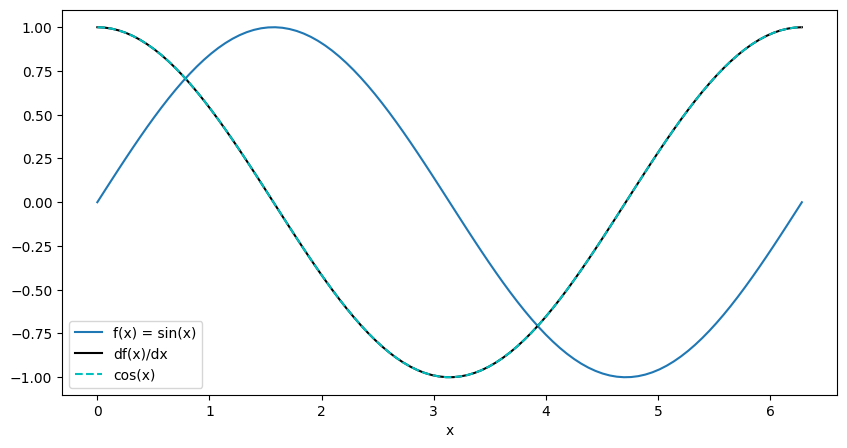

In [53]:
import matplotlib.pyplot as plt

with torch.no_grad(): # do not compute gradients for plotting
    fig, axes = plt.subplots(1, 1, figsize=(10, 5))
    # Since GPU() is used, we need to move the tensor back to the CPU
    axes.plot(x.cpu().numpy(), z.cpu().numpy(), label='f(x) = sin(x)')
    axes.plot(x.cpu().numpy(), dz_dx.cpu().numpy(), "k-", label="df(x)/dx")
    axes.plot(x.cpu().numpy(), torch.cos(x).cpu().numpy(), "c--", label="cos(x)")
    axes.legend()
    axes.set_xlabel('x')

    plt.show()


### Can you perhaps extend this to 2D function in x and y


Consider the equation

$$
f(x, y) = \sin{(x+y)} = Z
$$
where $x,y \in [0., 2\pi]$

This can be broken down to

$$ v = x + y $$
$$ z = \sin{(v)} $$

In `autograd` the tensors `x` and `y` are called as leaves. During the forward pass, if the argument `requires_grad` is set to true, then derivates corresponding to each operations performed using the variable will be traced. This is true for intermediate leaf like the varible `v` as well. But storing the trace can be turned on or off by the argument `retain_grad`. Follow the blog [pytorch-autograd-engine](https://pytorch.org/blog/overview-of-pytorch-autograd-engine/) for more information

![](https://drive.google.com/uc?id=1bB7o16lSObD-Exz9-plMTQsRrxcKDJ1G)




One can verify if all works by doing the following
$$
\begin{align}
\vec{\nabla} f(x, y) &=
\hat{i}\frac{\partial}{\partial x}\sin{(x+y)} + \hat{j} \frac{\partial}{\partial y}\sin{(x + y)}
\end{align}
$$


hence, if we do
$$f^{2} + \frac{1}{2}| \vec{\nabla}f| ^{2} = 1$$


<ipython-input-54-a90db44b204b>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
<ipython-input-54-a90db44b204b>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
<ipython-input-54-a90db44b204b>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])


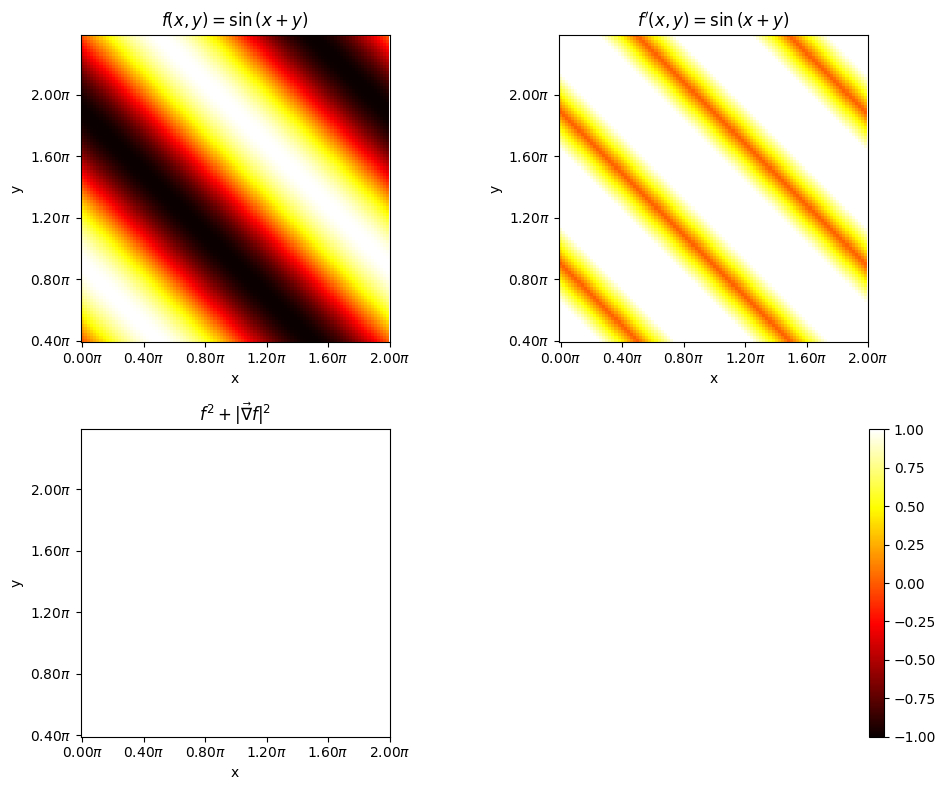

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# create a linspace in x from -5 to 5
x = torch.linspace(0., 2*torch.pi, 100, requires_grad=False, **tkwargs)
y = torch.linspace(0., 2*torch.pi, 100, requires_grad=False, **tkwargs)
X, Y = torch.meshgrid(x, y, indexing = "xy")
X.requires_grad = True
Y.requires_grad = True
V = X + Y
V.retain_grad()

Z = torch.sin(V)
Z.retain_grad()

# Lets compute the gradients
Z.backward(torch.ones_like(Z))

# switch off tracing
with torch.no_grad():
    dz_dx = X.grad
    dz_dy = Y.grad
    # plot imshow first
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    # normalize color to -1 to 1
    f = axes[0, 0].imshow(Z.cpu().numpy(), cmap='hot', vmin=-1, vmax=1, origin = "lower")
    axes[0, 0].set_title(r"$f(x, y) = \sin{(x+y)}$")
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    # set axis labels to go from 0 to 2pi
    axes[0, 0].set_xticks(np.linspace(0., 100., 6))
    axes[0, 0].set_xticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    axes[0, 0].set_xticks(np.linspace(0., 100., 6))
    axes[0, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])

    # compute zprime = dz_dx + dz_dy
    Zprime = torch.sqrt(dz_dx**2 + dz_dy**2)
    zprme = axes[0, 1].imshow(Zprime.cpu().numpy(), cmap = 'hot', vmin = -1, vmax = 1, origin = "lower")
    axes[0, 1].set_title(r"$f^{\prime}(x, y) = \sin{(x+y)}$")
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    # set axis labels to go from 0 to 2pi
    axes[0, 1].set_xticks(np.linspace(0., 100., 6))
    axes[0, 1].set_xticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    axes[0, 1].set_xticks(np.linspace(0., 100., 6))
    axes[0, 1].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])

    # compute z**2 + 1/4 z**2'
    added = Z**2 + (1/2.)*Zprime**2
    axes[1, 0].imshow(added.cpu().numpy(), cmap = 'hot', vmin = -1, vmax = 1, origin = "lower")
    axes[1, 0].set_title(r"$f^{2} + |\vec{\nabla} f|^{2}$")
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    # set axis labels to go from 0 to 2pi
    axes[1, 0].set_xticks(np.linspace(0., 100., 6))
    axes[1, 0].set_xticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    axes[1, 0].set_xticks(np.linspace(0., 100., 6))
    axes[1, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    #place the color bar on the top of the figure not wihtin any subplots
    axes[1, 1].set_axis_off()
    fig.colorbar(zprme, ax = axes[1, 1], orientation = "vertical")
    plt.tight_layout()
    plt.show()

If $V = X+Y$ then,

$$
\frac{\partial Z}{\partial V} = \frac{\partial \sin{(V)}}{\partial V} = \cos{(V)}
$$

Hence

<ipython-input-55-5f9c4e8aec3a>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
<ipython-input-55-5f9c4e8aec3a>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
<ipython-input-55-5f9c4e8aec3a>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])


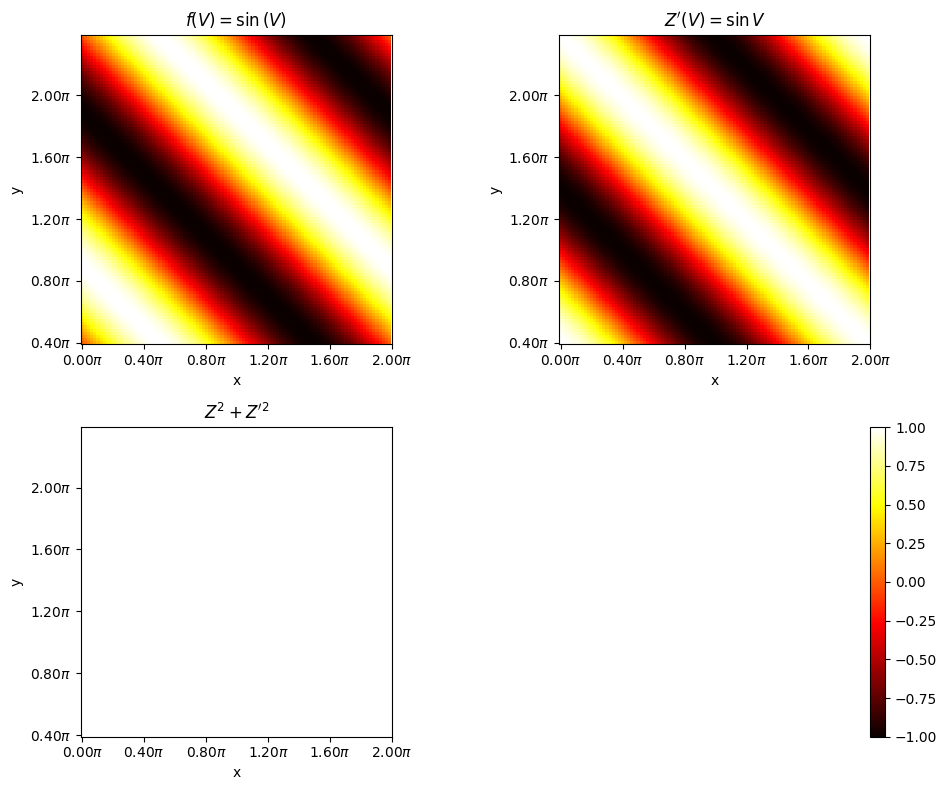

In [55]:
#@title $Z^{2} + Z^{\prime 2} = 1$

# switch off tracing
with torch.no_grad():
    dz_dx = X.grad
    dz_dy = Y.grad
    # plot imshow first
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    # normalize color to -1 to 1
    f = axes[0, 0].imshow(Z.cpu().numpy(), cmap='hot', vmin=-1, vmax=1, origin = "lower")
    axes[0, 0].set_title(r"$f(V) = \sin{(V)}$")
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    # set axis labels to go from 0 to 2pi
    axes[0, 0].set_xticks(np.linspace(0., 100., 6))
    axes[0, 0].set_xticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    axes[0, 0].set_xticks(np.linspace(0., 100., 6))
    axes[0, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])

    # compute zprime = dz_dx + dz_dy
    dz_dv = V.grad
    zprme = axes[0, 1].imshow(dz_dv.cpu().numpy(), cmap = 'hot', vmin = -1, vmax = 1, origin = "lower")
    axes[0, 1].set_title(r"$Z^{\prime}(V) = \sin{V}$")
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    # set axis labels to go from 0 to 2pi
    axes[0, 1].set_xticks(np.linspace(0., 100., 6))
    axes[0, 1].set_xticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    axes[0, 1].set_xticks(np.linspace(0., 100., 6))
    axes[0, 1].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])

    # compute z**2 + 1/4 z**2'
    added = Z**2 + Zprime**2
    axes[1, 0].imshow(added.cpu().numpy(), cmap = 'hot', vmin = -1, vmax = 1, origin = "lower")
    axes[1, 0].set_title(r"$Z^{2} + Z^{\prime 2}$")
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    # set axis labels to go from 0 to 2pi
    axes[1, 0].set_xticks(np.linspace(0., 100., 6))
    axes[1, 0].set_xticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    axes[1, 0].set_xticks(np.linspace(0., 100., 6))
    axes[1, 0].set_yticklabels([f"{i:.2f}" + r"$\pi$" for i in np.linspace(0., 2., 6)])
    #place the color bar on the top of the figure not wihtin any subplots
    axes[1, 1].set_axis_off()
    fig.colorbar(zprme, ax = axes[1, 1], orientation = "vertical")
    plt.tight_layout()
    plt.show()

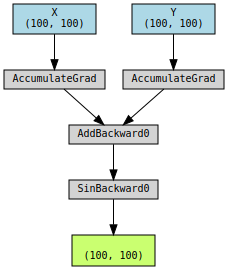

In [58]:
import torchviz

torchviz.make_dot(Z, {'X': X, 'Y': Y, 'V': V})

## Simplifying implementations of common architectures via the torch.nn module



### Implementing models based on nn.Sequential

In [59]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

#### Configuring layers

 * Initializers `nn.init`: https://pytorch.org/docs/stable/nn.init.html
 * L1 Regularizers `nn.L1Loss`: https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss
 * L2 Regularizers `weight_decay`: https://pytorch.org/docs/stable/optim.html
 * Activations: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity  


In [60]:
nn.init.xavier_uniform_(model[0].weight)

l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()


#### Compiling a model

 * Optimizers `torch.optim`:  https://pytorch.org/docs/stable/optim.html#algorithms
 * Loss Functions `tf.keras.losses`: https://pytorch.org/docs/stable/nn.html#loss-functions

In [61]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

## Effect of zeroing out gradients


In [62]:
import torch

# Define a simple linear model: y = wx
w = torch.tensor([2.0], requires_grad=True)  # Initialize weight w
x = torch.tensor([1.0])  # Input value
y_true = torch.tensor([4.0])  # True value (target)

# Define a learning rate
learning_rate = 0.1

# Optimizer (Gradient Descent)
optimizer = torch.optim.SGD([w], lr=learning_rate)

# Define a simple Mean Squared Error (MSE) loss function
def loss_fn(y_pred, y_true):
    return (y_pred - y_true).pow(2).mean()

# Step 1: Forward pass and loss computation
y_pred = w * x
loss = loss_fn(y_pred, y_true)

# Backward pass (compute gradients)
loss.backward()

print(f"Gradients after step 1: {w.grad}")

# Step 2: Update weights without zeroing gradients
optimizer.step()  # This updates w using the gradient

# Forward pass again after the update
y_pred = w * x
loss = loss_fn(y_pred, y_true)

# Compute new gradients
loss.backward()

print(f"Gradients after step 2 without zeroing: {w.grad}")



Gradients after step 1: tensor([-4.])
Gradients after step 2 without zeroing: tensor([-7.2000])


In [63]:
# Now lets do it the right way

# Reset the weight and gradient
w = torch.tensor([2.0], requires_grad=True)
optimizer = torch.optim.SGD([w], lr=learning_rate)

# Step 1: Forward pass and loss computation
y_pred = w * x
loss = loss_fn(y_pred, y_true)
loss.backward()

print(f"Gradients after step 1: {w.grad}")

# Update weights
optimizer.step()

# Zero the gradients
optimizer.zero_grad()

# Step 2: Forward pass again after zeroing
y_pred = w * x
loss = loss_fn(y_pred, y_true)
loss.backward()

print(f"Gradients after step 2 with zeroing: {w.grad}")


Gradients after step 1: tensor([-4.])
Gradients after step 2 with zeroing: tensor([-3.2000])


## Solving an XOR classification problem

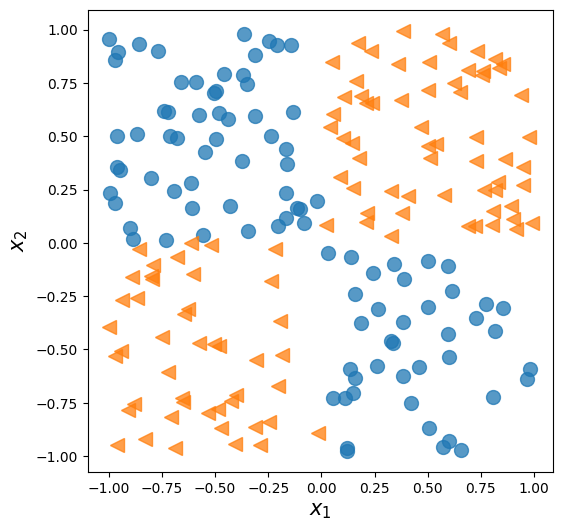

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0],
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0],
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)

#plt.savefig('figures/13_02.png', dpi=300)
plt.show()

In [65]:
from torch.utils.data import DataLoader, TensorDataset


train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)


In [66]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model


Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [67]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [68]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

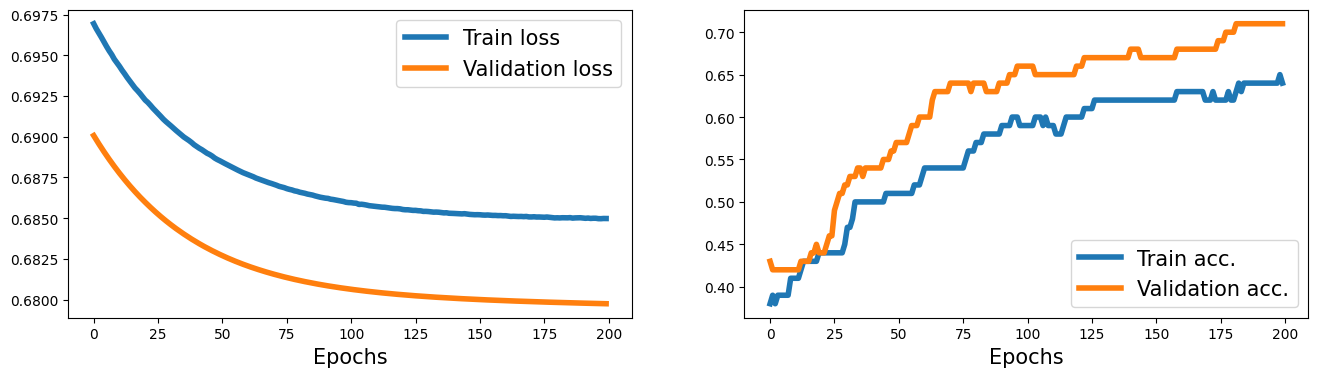

In [69]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_03.png', dpi=300)

In [70]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [71]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

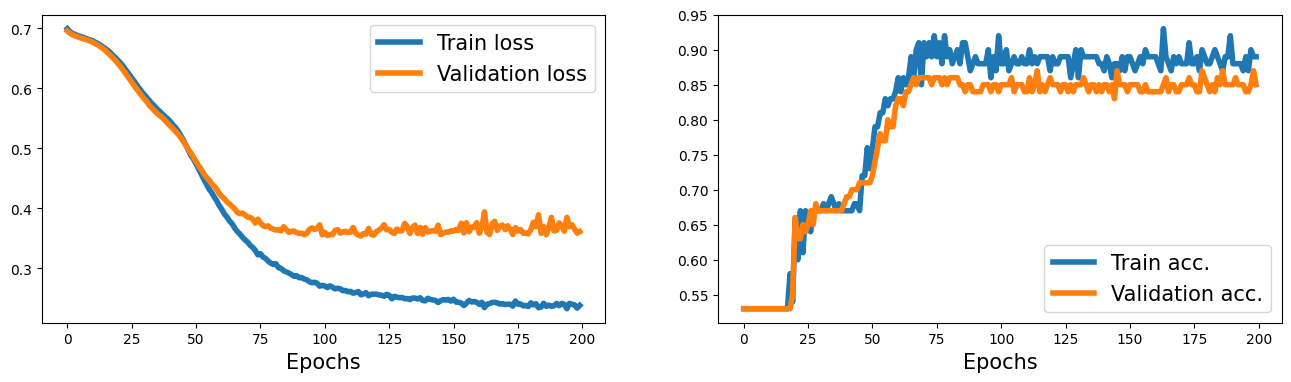

In [72]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plt.savefig('figures/13_04.png', dpi=300)

## Making model building more flexible with nn.Module



In [73]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)

    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

model = MyModule()
model


MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [74]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

# torch.manual_seed(1)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

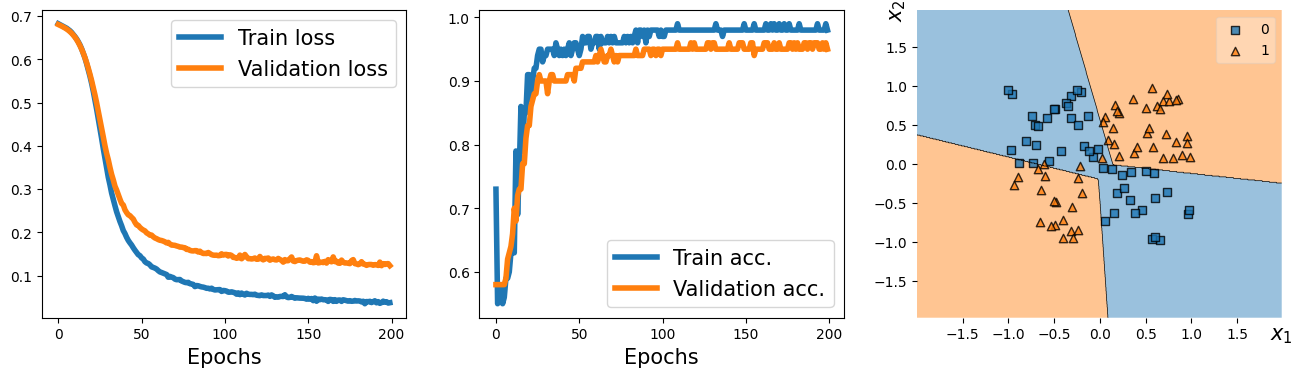

In [76]:
from mlxtend.plotting import plot_decision_regions # replacing the plot_decision function used in previous lectures


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(),
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_05.png', dpi=300)
plt.show()

## Writing custom layers in PyTorch


In [77]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)  # nn.Parameter is a Tensor that's a module parameter.
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

In [78]:
## testing:

torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)

x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=False))


tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [79]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model

MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [80]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

torch.manual_seed(1)

loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs
for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_hist_train[epoch] += is_correct.mean()

    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()

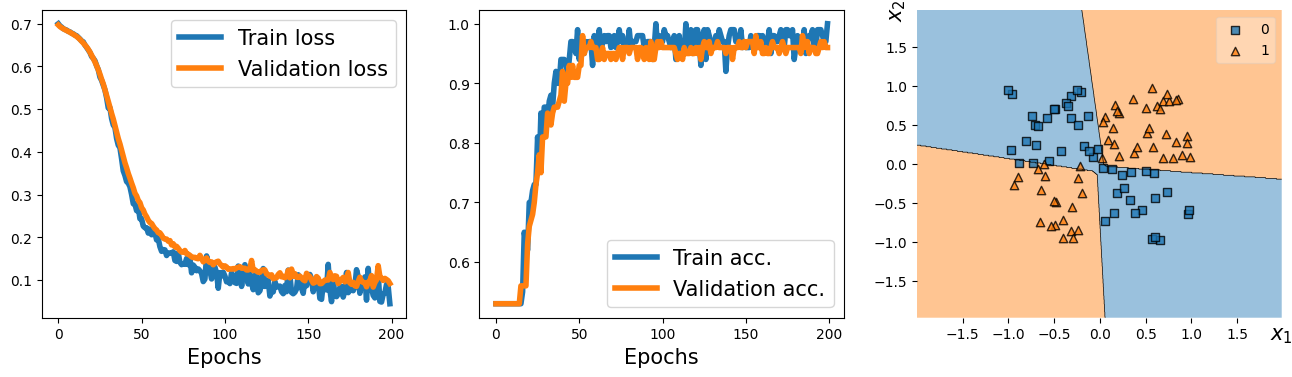

In [81]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(),
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

#plt.savefig('figures/13_06.png', dpi=300)
plt.show()

## Example 2 - lassifying MNIST hand-written digits

In [82]:
import torchvision
from torchvision import transforms # used for data preprocessing and augmentation
import torch
from torch.utils.data import DataLoader
from torch import nn
image_path = './'
transform = transforms.Compose([transforms.ToTensor()]) # transforms the images to tensors

mnist_train_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 21541640.71it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 611944.78it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 5457439.74it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4407803.97it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [83]:
hidden_units = [32, 16]
image_size = mnist_train_dataset[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

all_layers = [nn.Flatten()]
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 10))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')

Epoch 0  Accuracy 0.8531
Epoch 1  Accuracy 0.9287
Epoch 2  Accuracy 0.9413
Epoch 3  Accuracy 0.9506
Epoch 4  Accuracy 0.9558
Epoch 5  Accuracy 0.9592


## Dynamic Net

To showcase the power of PyTorch dynamic graphs, we will implement a very strange model: a fully-connected ReLU network that on each forward pass randomly chooses a number between 1 and 4 and has that many hidden layers, reusing the same weights multiple times to compute the innermost hidden layers.

By Justin Johnson: https://github.com/jcjohnson/pytorch-examples/blob/master/nn/dynamic_net.py.

In [ ]:
import random


class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(DynamicNet, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.middle_linear = torch.nn.Linear(H, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x, verbose=False):
        """
        For the forward pass of the model, we randomly choose either 0, 1, 2, or 3
        and reuse the middle_linear Module that many times to compute hidden layer
        representations.
        Since each forward pass builds a dynamic computation graph, we can use normal
        Python control-flow operators like loops or conditional statements when
        defining the forward pass of the model.
        Here we also see that it is perfectly safe to reuse the same Module many
        times when defining a computational graph. This is a big improvement from Lua
        Torch, where each Module could be used only once.
        """
        h_relu = self.input_linear(x).clamp(min=0)
        n_layers = random.randint(0, 3)
        if verbose:
            print("The number of layers for this run is", n_layers)
            # print(h_relu)
        for _ in range(n_layers):
            h_relu = self.middle_linear(h_relu).clamp(min=0)
            if verbose:
                pass
                # print(h_relu)
        y_pred = self.output_linear(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 10, 1

# Create random Tensors to hold inputs and outputs, and wrap them in Variables
x = torch.randn(N, D_in)
y = torch.randn(N, D_out).requires_grad_(False)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction="sum")
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f'Epoch {epoch}  Accuracy {accuracy_hist_train:.4f}')